# Homework 3 - Pedestrian Detection using Histogram of Oriented Gradients

## Topics:
- Data Preparation
- Feature extraction: Histogram of Oriented Gradients
- Classification: Support Vector Machine
- Object Detection: Sliding Window + Non Maximum Supression


## Sources & Material
- Datasets: 
    - https://www.cis.upenn.edu/~jshi/ped_html/
    - http://pascal.inrialpes.fr/data/human/
- Dataset preprocessed: https://github.com/RashadGarayev/PersonDetection
- Paper: Dalal and Triggs, “Histograms of oriented gradients for human detection,” CVPR05
    - https://hal.inria.fr/inria-00548512/document/
    
## Further Reading
- https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/
 

# 1. Import Libraries
- OpenCV
- scikit-image
- scikit-learn

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import os
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, f1_score, recall_score, precision_score

import utils

# 2. Prepare Data 

1. Create a dataset by loading all images
    - positive samples that contain pedestrians
    - negative samples that contain background objects
2. Split data into training and test data
    - split positive examples 
    - split negative examples

In [3]:
# Read Image files from local file system
positive_files = utils.ls("dataset/positive/")
negative_files = utils.ls("dataset/negative/")

split_pos = int(0.7*len(positive_files))
split_neg = int(0.7*len(negative_files))

train_positive_files, test_positive_files =  positive_files[:split_pos], positive_files[split_pos:]
train_negative_files, test_negative_files =  negative_files[:split_neg], negative_files[split_neg:]

# TODO: 
# Read the images and store them in their corresponding lists
train_positive = np.array([cv.imread(img) for img in train_positive_files])
train_negative = np.array([cv.imread(img) for img in train_negative_files])

test_positive = np.array([cv.imread(img) for img in test_positive_files])
test_negative = np.array([cv.imread(img) for img in test_negative_files])

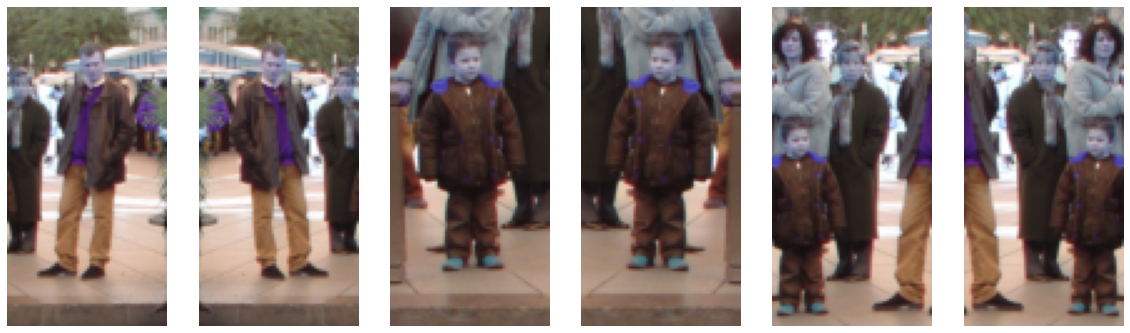

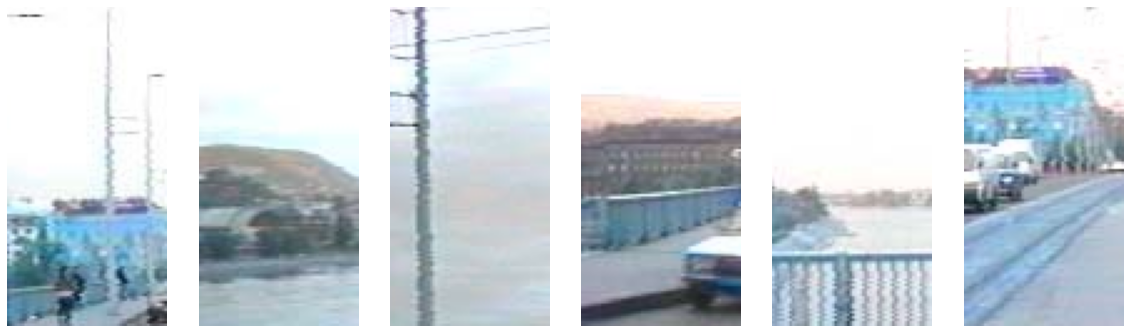

In [4]:
# You can visualize the examples:
utils.showImages(train_positive[:6])
utils.showImages(train_negative[:6])

# 3. Feature Extraction

1. Apply Histogram of Oriented Gradients on all data
2. Create Training Labels

## HOG -  Example

<ipython-input-5-7684c1143286>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),


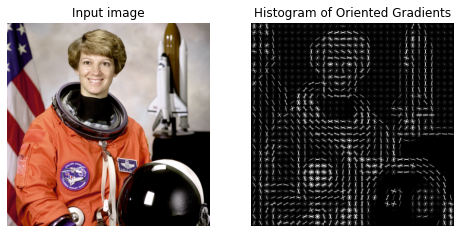

In [5]:
from skimage import data


img = data.astronaut()


fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(3, 3), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## 3.1 Compute HOG for each Image

In [6]:
def feature_extraction(img, ppc = 8, cpb = 2, grayscale=True):
    """
    img: A coloured image
    ppc: Pixels per cell
    cpb: Cells per block
    
    return: HOG feature vector 
    The 
    """
    # TODO: compute HOG feature vector
    # - try different parameters 
    # - the output should be a one-dimensional array
    if grayscale is True:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return hog(img, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), feature_vector=True)


# Training Samples
train_positive_hog = np.array([feature_extraction(img) for img in train_positive])
train_negative_hog = np.array([feature_extraction(img) for img in train_negative])

# Testing Samples
test_positive_hog = np.array([feature_extraction(img) for img in test_positive])
test_negative_hog = np.array([feature_extraction(img) for img in test_negative])

# 3.2 Labels

In [7]:
# Combine positive and negative samples into data matrices 
X = np.concatenate((train_positive_hog,train_negative_hog))
X_test = np.concatenate((test_positive_hog,test_negative_hog))

# Create array of corresponding labels
Y = np.zeros(len(X))
Y[:len(train_positive_hog)] = 0
Y[len(train_positive_hog):] = 1

Y_test = np.zeros(len(X_test))
Y_test[:len(test_positive_hog)] = 0
Y_test[len(test_positive_hog):] = 1

# 4. Classifier

1. Initialize Model
2. Train Model
3. Evaluate Model

# 4.1 & 4.2

In [8]:
svc = svm.LinearSVC(C=0.6,max_iter=10000)
svc.fit(X,Y)

LinearSVC(C=0.6, max_iter=10000)

# 4.3 Evaluate Model

In [9]:
Y_pred = svc.predict(X_test)

# Confusion Matrix
$$C = \left( \begin{matrix} \text{True Negatives} & \text{False Positives} \\ \text{False Negatives} & \text{True Positives} \end{matrix} \right) $$

In [10]:
confusion_matrix(Y_test,Y_pred)

array([[ 664,   61],
       [  64, 1172]], dtype=int64)

In [11]:
print("AP:", average_precision_score(Y_test,Y_pred))
print("Accuracy:", accuracy_score(Y_test,Y_pred))
print("Recall:", recall_score(Y_test,Y_pred))
print("Precision:", precision_score(Y_test,Y_pred))
print("F1:", f1_score(Y_test,Y_pred))

AP: 0.9339453441859834
Accuracy: 0.9362570117287098
Recall: 0.948220064724919
Precision: 0.9505271695052717
F1: 0.9493722154718509


# 5. How to use the classifier on real images

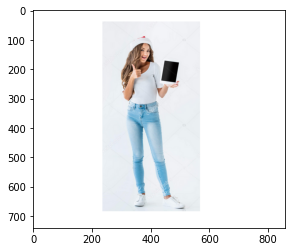

In [89]:
# img = cv.imread("Images/test.jpg")[:,:,::-1]
img = cv.imread("Images/Untitled.png")[:,:,::-1]
scale = 1
img = cv.resize(img, (int(scale*img.shape[1]),int(scale*img.shape[0]))) 
plt.imshow(img)
plt.show()

In [90]:
step, height, width = 10, 128, 64
import utils
def detect(img, svc, step = 10, height = 128, width = 64):
    """
    img: any image
    svc: Support Vector Classifier
    step: Step size of window operation
    
    return:
        result: a matrix with the predicted labels result[i,j] != 0 means that at the given window a pedestrian was found
        bounding_boxes [N, 4]: A matrix of bounding boxes corresponding to found pedestrians. 
        bounding_boxes[i,0:2] describe the upper left corner and bounding_boxes[i,2:4] describe the bottom right corner. 
    """
    # Iterate over image and apply classifier
    result = np.zeros(img.shape[:2])-1
    for i in range(0,img.shape[0]-height, step):
        for j in range(0,img.shape[1]-width, step):
            result[i,j] = svc.predict(feature_extraction(img[i:i+height,j:j+width]).reshape(1, -1))[0]
    
    y, x = np.nonzero(result==0)
    bounding_boxes = np.stack([x, y, x+width, y+height], axis=1)
    return result, bounding_boxes
            
result, bounding_boxes = detect(img, svc, step, height, width)

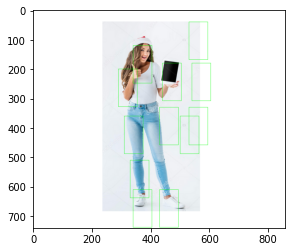

In [91]:
bounding_boxes_filtered = utils.non_max_suppression_fast(bounding_boxes, 0.5)

res = img.copy()
for i in range(len(bounding_boxes_filtered)):
    x_1, y_1 = bounding_boxes_filtered[i,0],bounding_boxes_filtered[i,1]
    x_2, y_2 = bounding_boxes_filtered[i,2],bounding_boxes_filtered[i,3]
    
    res = cv.rectangle(res.astype(np.float32),(x_1, y_1),(x_2, y_2),(0,255,0),1).astype(np.uint8)

plt.imshow(res)
plt.show()

# 6 Deploy Model on Multiple Scales

The model only detects pedestrians in a specific resolution (64x128).
Extend the application of the model to any resolution.

TODO
- Scale the images 
- Detect people
- apply nonmaxima supression over multiple scales

Size of img_scaled: (741, 857)
Window size: 8192
Size of img_scaled: (371, 429)
Window size: 32768
Size of img_scaled: (186, 215)
Window size: 131072


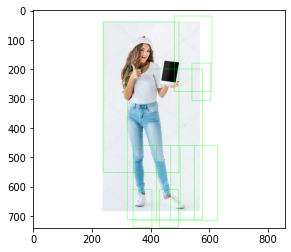

In [85]:
img = cv.imread("Images/Untitled.png")[:,:,::-1]
scale = 1
img = cv.resize(img, (int(scale*img.shape[1]),int(scale*img.shape[0])))
downscale = 2  # Ratio for the pyramid
detections = []

import utils
from skimage.transform import pyramid_gaussian
def detect_multiscale(img, svc, downscale=3, step = 10, height = 128, width = 64):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    scale = 0
    for img_scaled in pyramid_gaussian(img, downscale=downscale):
        
        # Stop if resized image is smaller than minimum sliding window
        if img_scaled.shape[0] < height or img_scaled.shape[1] < width:
            break
        
        # Iterate over image and apply classifier
        result = np.zeros(img_scaled.shape[:2])-1
        print(f"Size of img_scaled: {img_scaled.shape}")
        for i in range(0, img_scaled.shape[0]-height, step):
            for j in range(0, img_scaled.shape[1]-width, step):
                window = img_scaled[i:i+height, j:j+width]
                fd = hog(window, cells_per_block=(2,2), feature_vector=True).reshape(1, -1)
                if svc.predict(fd) == 0:
                    # If pedestrian detected, insert scaled window
                    y, x = int(i * (downscale**scale)), int(j * (downscale**scale))
                    w, h = int(x + width * (downscale**scale)), int(y + height * (downscale**scale))
                    detections.append((x, y, w, h))
                    
        print(f"Window size: {(w-x)*(h-y)}")
        scale += 1
    return result, detections

result, detections = detect_multiscale(img, svc, downscale, step, height, width)
bounding_boxes = np.array(detections)
bounding_boxes_filtered = utils.non_max_suppression_fast(bounding_boxes, 0.5)
res = img.copy()
for i in range(len(bounding_boxes_filtered)):
    x_1, y_1 = bounding_boxes_filtered[i,0],bounding_boxes_filtered[i,1]
    x_2, y_2 = bounding_boxes_filtered[i,2],bounding_boxes_filtered[i,3]
    
    res = cv.rectangle(res.astype(np.float32), (x_1, y_1), (x_2, y_2), (0,255,0), 1).astype(np.uint8)

plt.imshow(res)
plt.show()